In [1]:
#===============================================================================
# Copyright 2014-2021 Intel Corporation
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#===============================================================================

#  XGBoost Classification Model Using daal4py prediction

In this example we will train a XGBoost model and predict using the daal4py prediction method for increased performance. Intel optimized XGBoost and daal4py shipped as a part of the oneAPI AI Analytics Toolkit.

This example is a Jupyter Notebook version of this XGBoost daal4py prediction example: https://github.com/IntelPython/daal4py/blob/master/examples/gbt_cls_model_create_from_xgboost_batch.py

## Example Environment Creation

The environment for this example is the latest [Intel® oneAPI AI Analytics Toolkit](https://software.intel.com/content/www/us/en/develop/tools/oneapi/ai-analytics-toolkit.html) intel-aikit-modin environment, which includes data analytics and machine learning workflows such as daal4py, and Intel optimizations for XGboost.

## Importing and Organizing Data

Let's start by **importing** all necessary data and packages.


In [2]:
import daal4py as d4p
import xgboost as xgb
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt 

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Now let's **load** in the dataset and **organize** it as necessary to work with our model.

In [3]:
def pd_read_csv(f, c=None, t=np.float64):
    return pd.read_csv(f, usecols=c, delimiter=',', header=None, dtype=t)

In [4]:
readcsv=pd_read_csv
# Path to data
train_file = "./data/batch/df_classification_train.csv"
test_file = "./data/batch/df_classification_test.csv"

# Data reading
X_train = readcsv(train_file, range(3), t=np.float32)
y_train = readcsv(train_file, range(3, 4), t=np.float32)
X_test = readcsv(test_file, range(3), t=np.float32)
y_test = readcsv(test_file, range(3, 4), t=np.float32)

# Datasets creation
xgb_train = xgb.DMatrix(X_train, label=np.array(y_train))
xgb_test = xgb.DMatrix(X_test, label=np.array(y_test))

## Training the Model

**Fitting and training the model** using the training dataset.

In [5]:
# training parameters setting
params = {
    'max_bin': 256,
    'scale_pos_weight': 2,
    'lambda_l2': 1,
    'alpha': 0.9,
    'max_depth': 8,
    'num_leaves': 2**8,
    'verbosity': 0,
    'objective': 'multi:softmax',
    'learning_rate': 0.3,
    'num_class': 5,
}

# Training
xgb_model = xgb.train(params, xgb_train, num_boost_round=100)

## Using daal4py for Prediction

### XGBoost Prediction

We will also make a prediction using XGBoost for accuracy/performance comparison.

In [6]:
# XGBoost prediction (for accuracy comparison)
t0 = time.time()
xgb_prediction = xgb_model.predict(xgb_test)
t1 = time.time()
xgb_errors_count = np.count_nonzero(xgb_prediction - np.ravel(y_test))

xgb_total = t1-t0

### daal4py Prediction

Now let's make a prediction using daal4py for increased performance.

In [7]:
# Conversion to daal4py
daal_model = d4p.get_gbt_model_from_xgboost(xgb_model)

# daal4py prediction
daal_predict_algo = d4p.gbt_classification_prediction(
    nClasses=params["num_class"],
    resultsToEvaluate="computeClassLabels",
    fptype='float'
)
t0 = time.time()
daal_prediction = daal_predict_algo.compute(X_test, daal_model)
t1 = time.time()
daal_errors_count = np.count_nonzero(daal_prediction.prediction -  y_test)

d4p_total = t1-t0

In [8]:
assert np.absolute(xgb_errors_count - daal_errors_count) == 0
y_test = np.ravel(y_test)
daal_prediction = np.ravel(daal_prediction.prediction)


## Accuracy & Performance Comparison: XGBoots Prediction vs. Daal4py Prediction
### No accuracy loss!

In [9]:
print("\nXGBoost prediction results (first 10 rows):\n", xgb_prediction[0:10])
print("\ndaal4py prediction results (first 10 rows):\n", daal_prediction[0:10])
print("\nGround truth (first 10 rows):\n", y_test[0:10])

print("XGBoost errors count:", xgb_errors_count)
print("XGBoost accuracy score:", 1 - xgb_errors_count / xgb_prediction.shape[0])

print("\ndaal4py errors count:", daal_errors_count)
print("daal4py accuracy score:", 1 - daal_errors_count / daal_prediction.shape[0])

print("\n XGBoost Prediction Time:", xgb_total)
print("\n daal4py Prediction Time:", d4p_total)
print("\nAll looks good!")


XGBoost prediction results (first 10 rows):
 [4. 2. 2. 2. 3. 1. 3. 4. 3. 4.]

daal4py prediction results (first 10 rows):
 [4. 2. 2. 2. 3. 1. 3. 4. 3. 4.]

Ground truth (first 10 rows):
 [4. 2. 2. 2. 3. 1. 3. 4. 3. 4.]
XGBoost errors count: 10
XGBoost accuracy score: 0.99

daal4py errors count: 10
daal4py accuracy score: 0.99

 XGBoost Prediction Time: 0.010839700698852539

 daal4py Prediction Time: 0.03711390495300293

All looks good!


### Visualizations

#### Performance

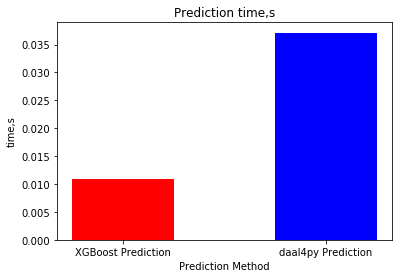

speedup: 0.2920657557478464


In [10]:
left = [1,2]
pred_times = [xgb_total, d4p_total]
tick_label = ['XGBoost Prediction', 'daal4py Prediction']
plt.bar(left, pred_times, tick_label = tick_label, width = 0.5, color = ['red', 'blue'])
plt.xlabel('Prediction Method'); plt.ylabel('time,s'); plt.title('Prediction time,s')
plt.show()
print("speedup:",xgb_total/d4p_total)

#### Accuracy

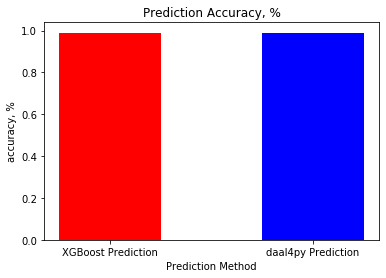

Accuracy Difference 0.0


In [11]:
left = [1,2]
xgb_acc = 1 - xgb_errors_count / xgb_prediction.shape[0]
d4p_acc = 1 - daal_errors_count / daal_prediction.shape[0]
pred_acc = [xgb_acc, d4p_acc]
tick_label = ['XGBoost Prediction', 'daal4py Prediction']
plt.bar(left, pred_acc, tick_label = tick_label, width = 0.5, color = ['red', 'blue'])
plt.xlabel('Prediction Method'); plt.ylabel('accuracy, %'); plt.title('Prediction Accuracy, %')
plt.show()
print("Accuracy Difference",xgb_acc-d4p_acc)

In [12]:
print("[CODE_SAMPLE_COMPLETED_SUCCESFULLY]")

[CODE_SAMPLE_COMPLETED_SUCCESFULLY]
